<a href="https://colab.research.google.com/github/yhame/ExData_Plotting1/blob/master/Copy_of_MIMIC_III_Datathon_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2018 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [0]:
abc

# Datathon Tutorial

The aim of this tutorial is to get you familiarized with BigQuery to query/filter/aggregate/export data with Python.

## Prerequisites

You should already have had a valid Gmail account registered with the datathon organizers.
  * If you do not have a Gmail account, you can create one at http://www.gmail.com. You need to notify datathon organizers to register your new account for data access.
  * If you have not yet signed the data use agreement (DUA) sent by the organizers, please do so immediately to get access to the MIMIC-III dataset.

## Setup

To be able to run the queries in this tutorial, you need to create a copy of this Colab notebook by clicking "File" > "Save a copy in Drive..." menu.
You can share your copy with your teammates by clicking on the "SHARE" button on the top-right corner of your Colab notebook copy. Everyone with "Edit" permission is able to modify the notebook at the same time, so it is a great way for team collaboration. Before running any cell in this colab, please make sure there is a green check mark before "CONNECTED" on top right corner, if not, please click "CONNECTED" button to connect to a random backend.

Now that you have done the initial setup, let us start playing with the data. First, you need to run some initialization code. You can run the following cell by clicking on the triangle button when you hover over the [ ] space on the top-left corner of the code cell below.

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

Before running any queries using BigQuery, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [0]:
auth.authenticate_user()

The data-hosting project `physionet-data` has read-only access, as a result, you need to set a default project that you have BigQuery access to. A shared project should be created by the event organizers, and we will be using it throughout this tutorial.

Note that during the datathon, all participants will be divided into teams and a Google Cloud project will be created for each team specifically. That project would be the preferred project to use. For now we'll stick with the shared project for the purpose of the tutorial.

After datathon is finished, the shared project may either lock down access or be deleted, it's still possible to run queries from a project you own personally as long as you have access to the dataset hosting project.

Change the variable project_id below to list the project you are using.

In [0]:
project_id='milan-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

Let's define a few methods to wrap BigQuery operations, so that we don't have to write the configurations again and again.

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

OK, that's it for setup, now let's get our hands on the MIMIC demo data!

## Analysis

Let's now run some queries adapted from the [MIMIC cohort selection tutorial](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb).

First let's run the following query to produce data to generate a histrogram graph to show the distribution of patient ages in ten-year buckets (i.e. [0, 10), [10, 20), ..., [90, ∞).

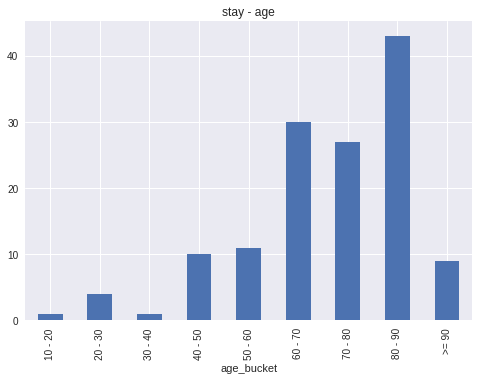

In [5]:
df = run_query('''
WITH ps AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    DATETIME_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
  FROM `physionet-data.mimiciii_demo.icustays` AS icu
  INNER JOIN `physionet-data.mimiciii_demo.patients` AS pat
    ON icu.subject_id = pat.subject_id),
bu AS (
  SELECT
    CAST(FLOOR(age / 10) AS INT64) AS bucket
  FROM ps)
SELECT
  COUNT(bucket) AS num_icu_stays,
  IF(bucket >= 9, ">= 90", FORMAT("%d - %d", bucket * 10, (bucket + 1) * 10)) AS age_bucket
FROM bu
GROUP BY bucket
ORDER BY bucket ASC
''')

df.set_index('age_bucket').plot(title='stay - age',kind='bar',legend=False)

The query consists of 3 parts:

1.   First we join `icustays` and `patients` tables to produce length of ICU stays in days for each patient, which is saved in a temporary table `ps`;
2.   Next we put patients into buckets based on their ages at the time they got admitted into ICU in `bu` table;
3.   The result data is filtered to include only the information required, i.e. `age_bucket` and `num_icu_stays`, to plot the chart.

**Note**: If you are having a hard time following the queries in this colab, or you want to know more about the table structures of MIMIC-III dataset, please consult [our colab for a previous Datathon held in Sydney](../../anzics18/tutorial.ipynb).

Now let's see if there is correlation between age and average length of stay in hours. Since we are using the age of patients when they get admitted, so we don't need to worry about multiple admissions of patients. Note that we treat the redacted ages (> 90) as noises and filter them out.

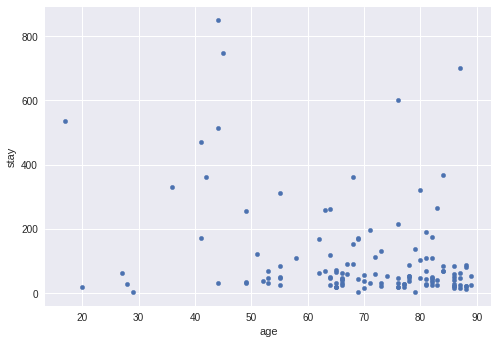

In [6]:
df = run_query('''
WITH re AS (
SELECT
  DATETIME_DIFF(icu.outtime, icu.intime, HOUR) AS icu_length_of_stay,
  DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
FROM `physionet-data.mimiciii_demo.icustays` AS icu
INNER JOIN `physionet-data.mimiciii_demo.patients` AS pat
  ON icu.subject_id = pat.subject_id)
SELECT
  icu_length_of_stay AS stay,
  age
FROM re
WHERE age < 100
''')

df.plot(kind='scatter',x='age',y='stay')

Let's take a look at another query which uses a filter that we often use, which is the current service that ICU patients are undergoing.

In [7]:
df = run_query('''
WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    DATETIME_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age,
    RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
  FROM `physionet-data.mimiciii_demo.icustays` AS icu
  INNER JOIN `physionet-data.mimiciii_demo.patients` AS pat
    ON icu.subject_id = pat.subject_id
  ORDER BY hadm_id DESC),
serv AS (
  SELECT
    icu.hadm_id,
    icu.icustay_id,
    se.curr_service,
    IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
    RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
  FROM `physionet-data.mimiciii_demo.icustays` AS icu
  LEFT JOIN `physionet-data.mimiciii_demo.services` AS se
   ON icu.hadm_id = se.hadm_id
  AND se.transfertime < DATETIME_ADD(icu.intime, INTERVAL 12 HOUR)
  ORDER BY icustay_id)
SELECT
  co.subject_id,
  co.hadm_id,
  co.icustay_id,
  co.icu_length_of_stay,
  co.age,
  IF(co.icu_length_of_stay < 2, 1, 0) AS short_stay,
  IF(co.icustay_id_order = 1, 0, 1) AS first_stay,
  IF(serv.surgical = 1, 1, 0) AS surgical
FROM co
LEFT JOIN serv USING (icustay_id, hadm_id)
WHERE
  serv.rank = 1 AND age < 100
ORDER BY subject_id, icustay_id_order
''')

print 'Number of rows in dataframe: %d' % len(df)
df.head()

Number of rows in dataframe: 127


,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,short_stay,first_stay,surgical
0,10006,142345,206504,2,70,0,0,0
1,10011,105331,232110,14,36,0,0,0
2,10013,165520,264446,3,87,0,0,0
3,10017,199207,204881,2,74,0,0,0
4,10019,177759,228977,2,49,0,0,0


This is a long query, but is pretty simple if we take a closer look. It consists of 3 steps as well:

1.   We are trying to know how many ICU admissions each patient has by joining `icustays` and `patients`. Note that since each patient may be admitted multiple times, we usually filter out follow-up ICU stays, and only keep the first one to minimize unwanted data correlation. This is achieved by partitioning over `subject_id`, and ordering by admission time, then choose only the first one with `RANK` function, the result is saved to a temporary table `co`;
2.   Next we are looking for first services in ICU stays for patients, and also adding a label to indicate whether last services before ICU admission were surgical, similarly the result is saved to `serv`;
3.   Lastly, we are ready to save this surgical exclusion label to a cohort generation table by joining the two tables, `co` and `serv`. For the convenience of later analysis, we rename some columns, and filter out patients more than 100 years old.

### ML Model Training

Next we will show an example of using [Tensorflow](https://www.tensorflow.org/) ([getting started doc](https://www.tensorflow.org/get_started/)) to build a simple predictor, where we use the patient's age and whether it is the first ICU stay to predict whether the ICU stay will be a short one. With only 127 data points in total, we don't expect to actually build an accurate or useful predictor, but it should serve the purpose of showing how a model can be trained and used using Tensorflow within Colab.

First, let us split the 127 data points into a training set with 100 records and a testing set with 27, and examine the distribution of the split sets to make sure that the distribution is similar.

In [8]:
data = df[['age', 'first_stay', 'short_stay']]
data.reindex(np.random.permutation(data.index))
training_df=data.head(100)
validation_df=data.tail(27)

print "Training data summary:"
display(training_df.describe())

print "Validation data summary:"
display(validation_df.describe())

Training data summary:


,age,first_stay,short_stay
count,100.000000,100.000000,100.000000
mean,68.730000,0.290000,0.300000
std,16.337263,0.456048,0.460566
min,17.000000,0.000000,0.000000
25%,64.000000,0.000000,0.000000
50%,70.500000,0.000000,0.000000
75%,81.000000,1.000000,1.000000
max,89.000000,1.000000,1.000000


Validation data summary:


,age,first_stay,short_stay
count,27.000000,27.000000,27.000000
mean,72.111111,0.222222,0.407407
std,13.951381,0.423659,0.500712
min,45.000000,0.000000,0.000000
25%,56.500000,0.000000,0.000000
50%,79.000000,0.000000,0.000000
75%,82.000000,0.000000,1.000000
max,89.000000,1.000000,1.000000


And let's quickly check the label distribution for the features.

age
short_stay first_stay     
0          0            50
           1            20
1          0            21
           1             9

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


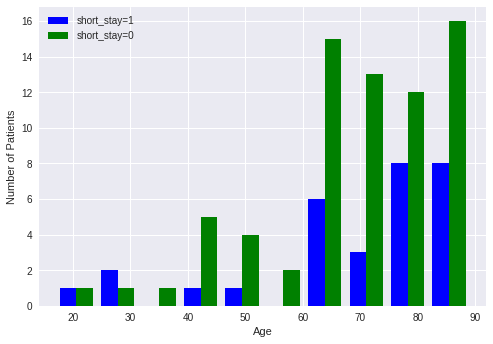

In [9]:
display(training_df.groupby(['short_stay', 'first_stay']).count())

fig, ax = plt.subplots()
shorts = training_df[training_df.short_stay==1].age
longs = training_df[training_df.short_stay==0].age
colors = ['b', 'g']
ax.hist([shorts, longs], bins=10, color=colors, label=['short_stay=1', 'short_stay=0'])
ax.set_xlabel('Age')
ax.set_ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.show()

Let's first build a linear regression model to predict the numeric value of "short_stay" based on age and first_stay features. You can tune the parameters on the right-hand side and observe differences in the evaluation result.

In [10]:
#@title Linear Regression Parameters {display-mode:"both"}
BATCH_SIZE = 5 # @param
NUM_EPOCHS = 100 # @param

first_stay = tf.feature_column.numeric_column('first_stay')
age = tf.feature_column.numeric_column('age')

# Build linear regressor
linear_regressor = tf.estimator.LinearRegressor(feature_columns=[first_stay, age])

# Train the Model.
model = linear_regressor.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=training_df,
        y=training_df['short_stay'],
        num_epochs=100,
        batch_size=BATCH_SIZE,
        shuffle=True),
    steps=100)

# Evaluate the model.
eval_result = linear_regressor.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=validation_df,
        y=validation_df['short_stay'],
        batch_size=BATCH_SIZE,
        shuffle=False))

display(eval_result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff61f7709d0>, '_model_dir': '/tmp/tmpHECGDy', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use

{'average_loss': 0.33905733,
 'global_step': 100,
 'label/mean': 0.4074074,
 'loss': 1.5257579,
 'prediction/mean': 0.08981858}

Remember that the label `short_stay` is actually categorical, with the value 1 for an ICU stay of 1 day or less and value 0 for stays of length 2 days or more. So a classification model better fits this task. Here we try a deep neural networks model using the `DNNClassifier` estimator. Notice the little changes from the regression code above.

In [11]:
#@title ML Training example {display-mode:"both"}
BATCH_SIZE = 5        # @param
NUM_EPOCHS = 100       # @param
HIDDEN_UNITS=[10, 10] # @param

# Build linear regressor
classifier = tf.estimator.DNNClassifier(
    feature_columns=[first_stay, age],
    hidden_units=HIDDEN_UNITS)

# Train the Model.
model = classifier.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=training_df,
        y=training_df['short_stay'],
        num_epochs=100,
        batch_size=BATCH_SIZE,
        shuffle=True),
    steps=100)

# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=validation_df,
        y=validation_df['short_stay'],
        batch_size=BATCH_SIZE,
        shuffle=False))

display(eval_result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff61ad95ed0>, '_model_dir': '/tmp/tmpnlE75H', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

{'accuracy': 0.5925926,
 'accuracy_baseline': 0.5925926,
 'auc': 0.4517045,
 'auc_precision_recall': 0.35527104,
 'average_loss': 0.6906012,
 'global_step': 100,
 'label/mean': 0.4074074,
 'loss': 3.1077054,
 'precision': 0.0,
 'prediction/mean': 0.36732313,
 'recall': 0.0}

Congratulations! Now you have finished this datathon tutorial, and ready to explore the real data by querying Google BigQuery. To do so, simply use `mimiciii_clinical` as the dataset name. For example, the table `mimiciii_demo.icustays` becomes `mimiciii_clinical.icustays` when you need the actual MIMIC data. One thing to note though, is that it is highly recommended to aggregate data aggressively wherever possible, because large dataframes may cause the performance of colab to drop drastically or even out of memory errors.

Now, let's do the substitution, and start the real datathon exploration.

Enjoy!